### Comparison of the coherence metric between the original and surrogate data

In [1]:
import sys
sys.path.insert(1, '/home/vinicius/storage1/projects/GrayData-Analysis')

import time
import os
import scipy
import h5py
import numpy                 as     np
import xarray                as     xr
import pandas                as     pd
import matplotlib.pyplot     as     plt
import seaborn               as     sns
from   tqdm                       import tqdm
from   xfrites.conn.conn_spec_plv import conn_spec_plv
from GDa.session                  import session_info, session
from GDa.signal.surrogates        import trial_swap_surrogates, phase_rand_surrogates
from GDa.temporal_network         import temporal_network
import GDa.stats.bursting    as     bst

In [2]:
raw_path = '/home/vinicius/storage1/projects/GrayData-Analysis'

In [85]:
# Extract area names
def _extract_roi(roi, sep):
    # Code by Etiene
    x_s, x_t = [], []
    for r in roi:
        _x_s, _x_t = r.split(sep)
        x_s.append(_x_s), x_t.append(_x_t)
    roi_c = np.c_[x_s, x_t]
    idx = np.argsort(np.char.lower(roi_c.astype(str)), axis=1)
    roi_s, roi_t = np.c_[[r[i] for r, i in zip(roi_c, idx)]].T
    roi_st = [f"{s}{sep}{t}" for s, t in zip(roi_s, roi_t)]
    return roi_s, roi_t, roi_st

#### Load data for a session

In [3]:
# Parameters to read the data
idx      = 3 
nses     = 1
nmonkey  = 0
align_to = 'cue'

dirs = { 'rawdata':os.path.join(raw_path, 'GrayLab'),
         'results':'Results/',
         'monkey' :['lucy', 'ethyl'],
         'session':'session01',
         'date'   :[['141014', '141015', '141205', '150128', '150211', '150304'], []] }

#  Instantiating session
ses   = session(raw_path = dirs['rawdata'], monkey = dirs['monkey'][nmonkey], date = dirs['date'][nmonkey][idx],
                session = nses, slvr_msmod = False, align_to = align_to, evt_dt = [-0.65, 3.00])
# Load data
ses.read_from_mat()

#### Compute PLV for the data

In [16]:
foi   = np.array([
        [0, 6.],
        [6., 14.],
        [14., 26.],
        [26., 42.],
        [42., 80.]
            ])
f_start, f_end, n_freqs, sfreq = .1, 80, 50, ses.data.attrs['fsample']
freqs = np.linspace(f_start, f_end, n_freqs, endpoint=True)
# define temporal windows + compute the DFC
n_cycles = freqs / 2.

kw = dict(
    freqs=freqs, times=None, roi=None, foi=foi, n_jobs=40,
    sfreq=ses.data.attrs['fsample'], mode='morlet', n_cycles=n_cycles, decim=15,
    block_size=1, kw_win=dict(slwin_len=.5,slwin_step=0.02)
)

# compute the coherence
plv = conn_spec_plv(ses.data.values, **kw).astype(np.float32)

WARNING | No time vector. A default one is created
WARNING | No regions of interest are provided (roi). Default ones are created
Defining temporal windows
    Definition of sliding windows (len=0.5, start=0.0, stop=3.645, step=0.02)
    158 windows defined
Compute spectral phase-locking value (n_pairs=1176, n_freqs=50, decim=15)
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done  20 out of  49 | elapsed:   19.7s remaining:   28.5s
[Parallel(n_jobs=40)]: Done  30 out of  49 | elapsed:   24.4s remaining:   15.4s
[Parallel(n_jobs=40)]: Done  40 out of  49 | elapsed:   29.1s remaining:    6.5s
[Parallel(n_jobs=40)]: Done  49 out of  49 | elapsed:   33.4s finished


  0%|          |  : 0/1176 [00:00<?,       ?it/s]

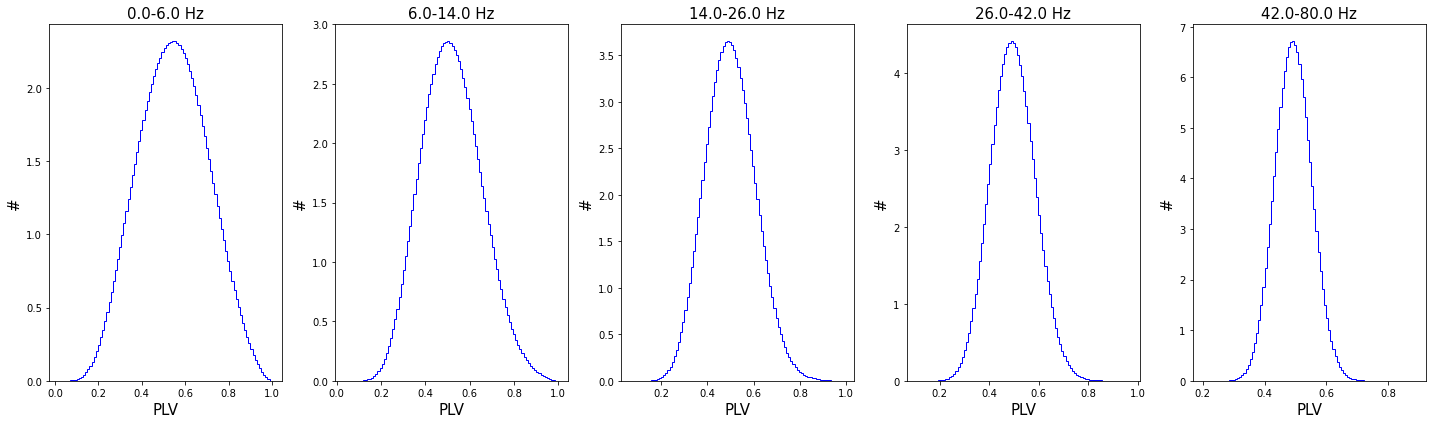

In [30]:
plt.figure(figsize=(20,6))
for f in range(plv.sizes['freqs']):
    plt.subplot(1, plv.sizes['freqs'], f+1)
    plt.hist( plv.isel(freqs=f).values.flatten(), density=True,bins=100, histtype='step', fill=False, color='b')
    plt.title(f'{foi[f,0]}-{foi[f,1]} Hz', fontsize=15)
    plt.xlabel('PLV', fontsize=15)
    plt.ylabel('#', fontsize=15)
plt.tight_layout()

#### Compute PLV for the surrogate data

In [32]:
data_surr = phase_rand_surrogates(ses.data, val=0, seed=0, verbose=True, n_jobs=-1)

  0%|          |  : 0/750 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:   10.0s
[Parallel(n_jobs=-1)]: Done 370 tasks      | elapsed:   11.8s
[Parallel(n_jobs=-1)]: Done 750 out of 750 | elapsed:   14.6s finished


In [33]:
# compute the coherence
plv_surr = conn_spec_plv(data_surr.values, **kw).astype(np.float32)

WARNING | No time vector. A default one is created
WARNING | No regions of interest are provided (roi). Default ones are created
Defining temporal windows
    Definition of sliding windows (len=0.5, start=0.0, stop=3.645, step=0.02)
    158 windows defined
Compute spectral phase-locking value (n_pairs=1176, n_freqs=50, decim=15)
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done  20 out of  49 | elapsed:   22.4s remaining:   32.5s
[Parallel(n_jobs=40)]: Done  30 out of  49 | elapsed:   27.1s remaining:   17.2s
[Parallel(n_jobs=40)]: Done  40 out of  49 | elapsed:   31.8s remaining:    7.1s
[Parallel(n_jobs=40)]: Done  49 out of  49 | elapsed:   35.9s finished


  0%|          |  : 0/1176 [00:00<?,       ?it/s]

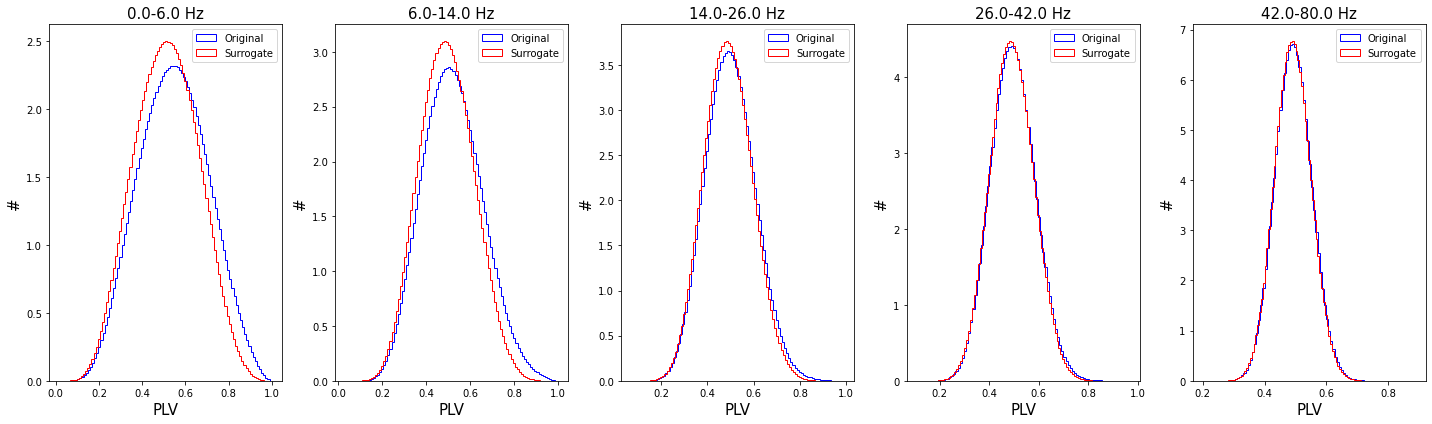

In [35]:
plt.figure(figsize=(20,6))
for f in range(plv.sizes['freqs']):
    plt.subplot(1, plv.sizes['freqs'], f+1)
    plt.hist( plv.isel(freqs=f).values.flatten(), density=True,bins=100, histtype='step', fill=False, color='b', label="Original")
    plt.hist( plv_surr.isel(freqs=f).values.flatten(), density=True,bins=100, histtype='step', fill=False, color='r', label="Surrogate")
    plt.legend()
    plt.title(f'{foi[f,0]}-{foi[f,1]} Hz', fontsize=15)
    plt.xlabel('PLV', fontsize=15)
    plt.ylabel('#', fontsize=15)
plt.tight_layout()

#### Statistical testing the distributions (KS-test and t-test)

In [58]:
extr

<xarray.DataArray 'plv' (trials: 750, roi: 1176, freqs: 5, times: 158)>
array([[[[0.6252397 , 0.6465512 , 0.68167305, ..., 0.60256934,
          0.6090553 , 0.6209253 ],
         [0.6493092 , 0.65276617, 0.6573155 , ..., 0.5060151 ,
          0.47710934, 0.45138654],
         [0.7439545 , 0.74556977, 0.74617577, ..., 0.40797257,
          0.39479727, 0.36851195],
         [0.55096   , 0.54702   , 0.56596243, ..., 0.38276833,
          0.38129395, 0.37719825],
         [0.35725042, 0.353393  , 0.37787086, ..., 0.43683356,
          0.43539593, 0.428973  ]],

        [[0.62087816, 0.6228832 , 0.6244074 , ..., 0.8432409 ,
          0.8429999 , 0.8399708 ],
         [0.58206004, 0.5527858 , 0.5372589 , ..., 0.6246654 ,
          0.61314255, 0.58097965],
         [0.7260411 , 0.70660096, 0.69736   , ..., 0.38834748,
          0.38741896, 0.38841647],
         [0.47039285, 0.48679048, 0.52493453, ..., 0.58119994,
          0.5832744 , 0.58572954],
         [0.45234576, 0.44879222, 0.46435937, ..., 0.41550285,
          0.39192063, 0.35371074]],

        [[0.67088294, 0.65779394, 0.64460385, ..., 0.8268573 ,
          0.817005  , 0.80409205],
         [0.657741  , 0.6142614 , 0.5942519 , ..., 0.6663235 ,
          0.6571531 , 0.6233478 ],
         [0.5531421 , 0.58919334, 0.6578073 , ..., 0.65129685,
          0.6615815 , 0.64273804],
         [0.39582562, 0.40965223, 0.44234157, ..., 0.53873515,
          0.549446  , 0.5507292 ],
         [0.5336767 , 0.53089046, 0.5426091 , ..., 0.49727184,
          0.4928487 , 0.48098302]],

        ...,

        [[0.7521388 , 0.7371289 , 0.7216326 , ..., 0.4547524 ,
          0.47978064, 0.53141177],
         [0.6516045 , 0.62147474, 0.59466785, ..., 0.8347671 ,
          0.83484864, 0.8395392 ],
         [0.5173793 , 0.5190569 , 0.5287044 , ..., 0.6092897 ,
          0.6105383 , 0.61815387],
         [0.6929747 , 0.6736976 , 0.67136234, ..., 0.53458005,
          0.55891937, 0.58505046],
         [0.47830993, 0.4454901 , 0.42597422, ..., 0.5722067 ,
          0.57735175, 0.57680815]],

        [[0.41211227, 0.4227338 , 0.47086895, ..., 0.6340094 ,
          0.6530252 , 0.68299365],
         [0.6125869 , 0.63395095, 0.688674  , ..., 0.60223657,
          0.62175953, 0.6410869 ],
         [0.49451014, 0.49564165, 0.5308821 , ..., 0.6976996 ,
          0.6869328 , 0.67160374],
         [0.5730551 , 0.5449553 , 0.5467177 , ..., 0.40160966,
          0.40543246, 0.41143817],
         [0.45542222, 0.44761834, 0.45766693, ..., 0.35429552,
          0.35748404, 0.36039603]],

        [[0.6196615 , 0.5598951 , 0.5499643 , ..., 0.7945561 ,
          0.79520714, 0.8121471 ],
         [0.64822686, 0.67117155, 0.7098866 , ..., 0.51702505,
          0.5352245 , 0.5584292 ],
         [0.5666342 , 0.56617254, 0.57105565, ..., 0.4676391 ,
          0.46719703, 0.46635556],
         [0.60911894, 0.604     , 0.60116965, ..., 0.45488182,
          0.45729423, 0.4527123 ],
         [0.5849572 , 0.56019866, 0.54647547, ..., 0.43944103,
          0.4362539 , 0.43716827]]],


       [[[0.3120211 , 0.2586497 , 0.23476967, ..., 0.4111399 ,
          0.39602923, 0.3548652 ],
         [0.6029886 , 0.5601487 , 0.54305583, ..., 0.44521743,
          0.4540411 , 0.4637851 ],
         [0.6710137 , 0.68498325, 0.69858736, ..., 0.5850395 ,
          0.5915756 , 0.5954234 ],
         [0.4584714 , 0.46236378, 0.469423  , ..., 0.45306477,
          0.45230025, 0.44313505],
         [0.5473285 , 0.53559834, 0.5302671 , ..., 0.47780955,
          0.47869462, 0.48108017]],

        [[0.42727202, 0.4186723 , 0.4309459 , ..., 0.47958472,
          0.4802246 , 0.4575804 ],
         [0.5618159 , 0.5394377 , 0.5317541 , ..., 0.51989   ,
          0.51307815, 0.49249023],
         [0.474173  , 0.5157405 , 0.5467254 , ..., 0.6341142 ,
          0.6391976 , 0.62878203],
         [0.4335317 , 0.4073155 , 0.39427403, ..., 0.5731603 ,
          0.55558187, 0.51009846],
         [0.49714398, 0.49383605, 0.5083012 , ..., 0.5489364 ,
          0.5

In [37]:
from scipy.stats import ks_2samp, ttest_ind

In [67]:
def significance_test(verbose=False, n_jobs=1):
    
    from frites.utils import parallel_func
    
    def _for_band(band):
        # Store p-value for KS-test
        ks = np.zeros(plv.shape[1])
        # Store p-value for t-test
        tt = np.zeros(plv.shape[1])
        for i in range( plv.shape[1] ):
            ks[i] = ks_2samp(plv.isel(freqs=band,roi=i).values.flatten(),plv_surr.isel(freqs=band,roi=i).values.flatten(),  alternative='two-sided')[1]
            tt[i] = ttest_ind(plv.isel(freqs=band,roi=i).values.flatten(),plv_surr.isel(freqs=band,roi=i).values.flatten(), alternative='two-sided')[1]
        return np.array([ks,tt])
    # define the function to compute in parallel
    parallel, p_fun = parallel_func( _for_band, n_jobs=n_jobs, 
                                     verbose=verbose, total=plv.shape[2]
                                   )
    p_values = parallel(p_fun(band) for band in range(plv.shape[2]))
    return np.asarray(p_values).T

In [68]:
p_values = significance_test(True,-1)

  0%|          |  : 0/5 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.9min finished


In [69]:
#p_values = np.mean(p_values, axis=0)

In [70]:
# p-values
p = 1/100

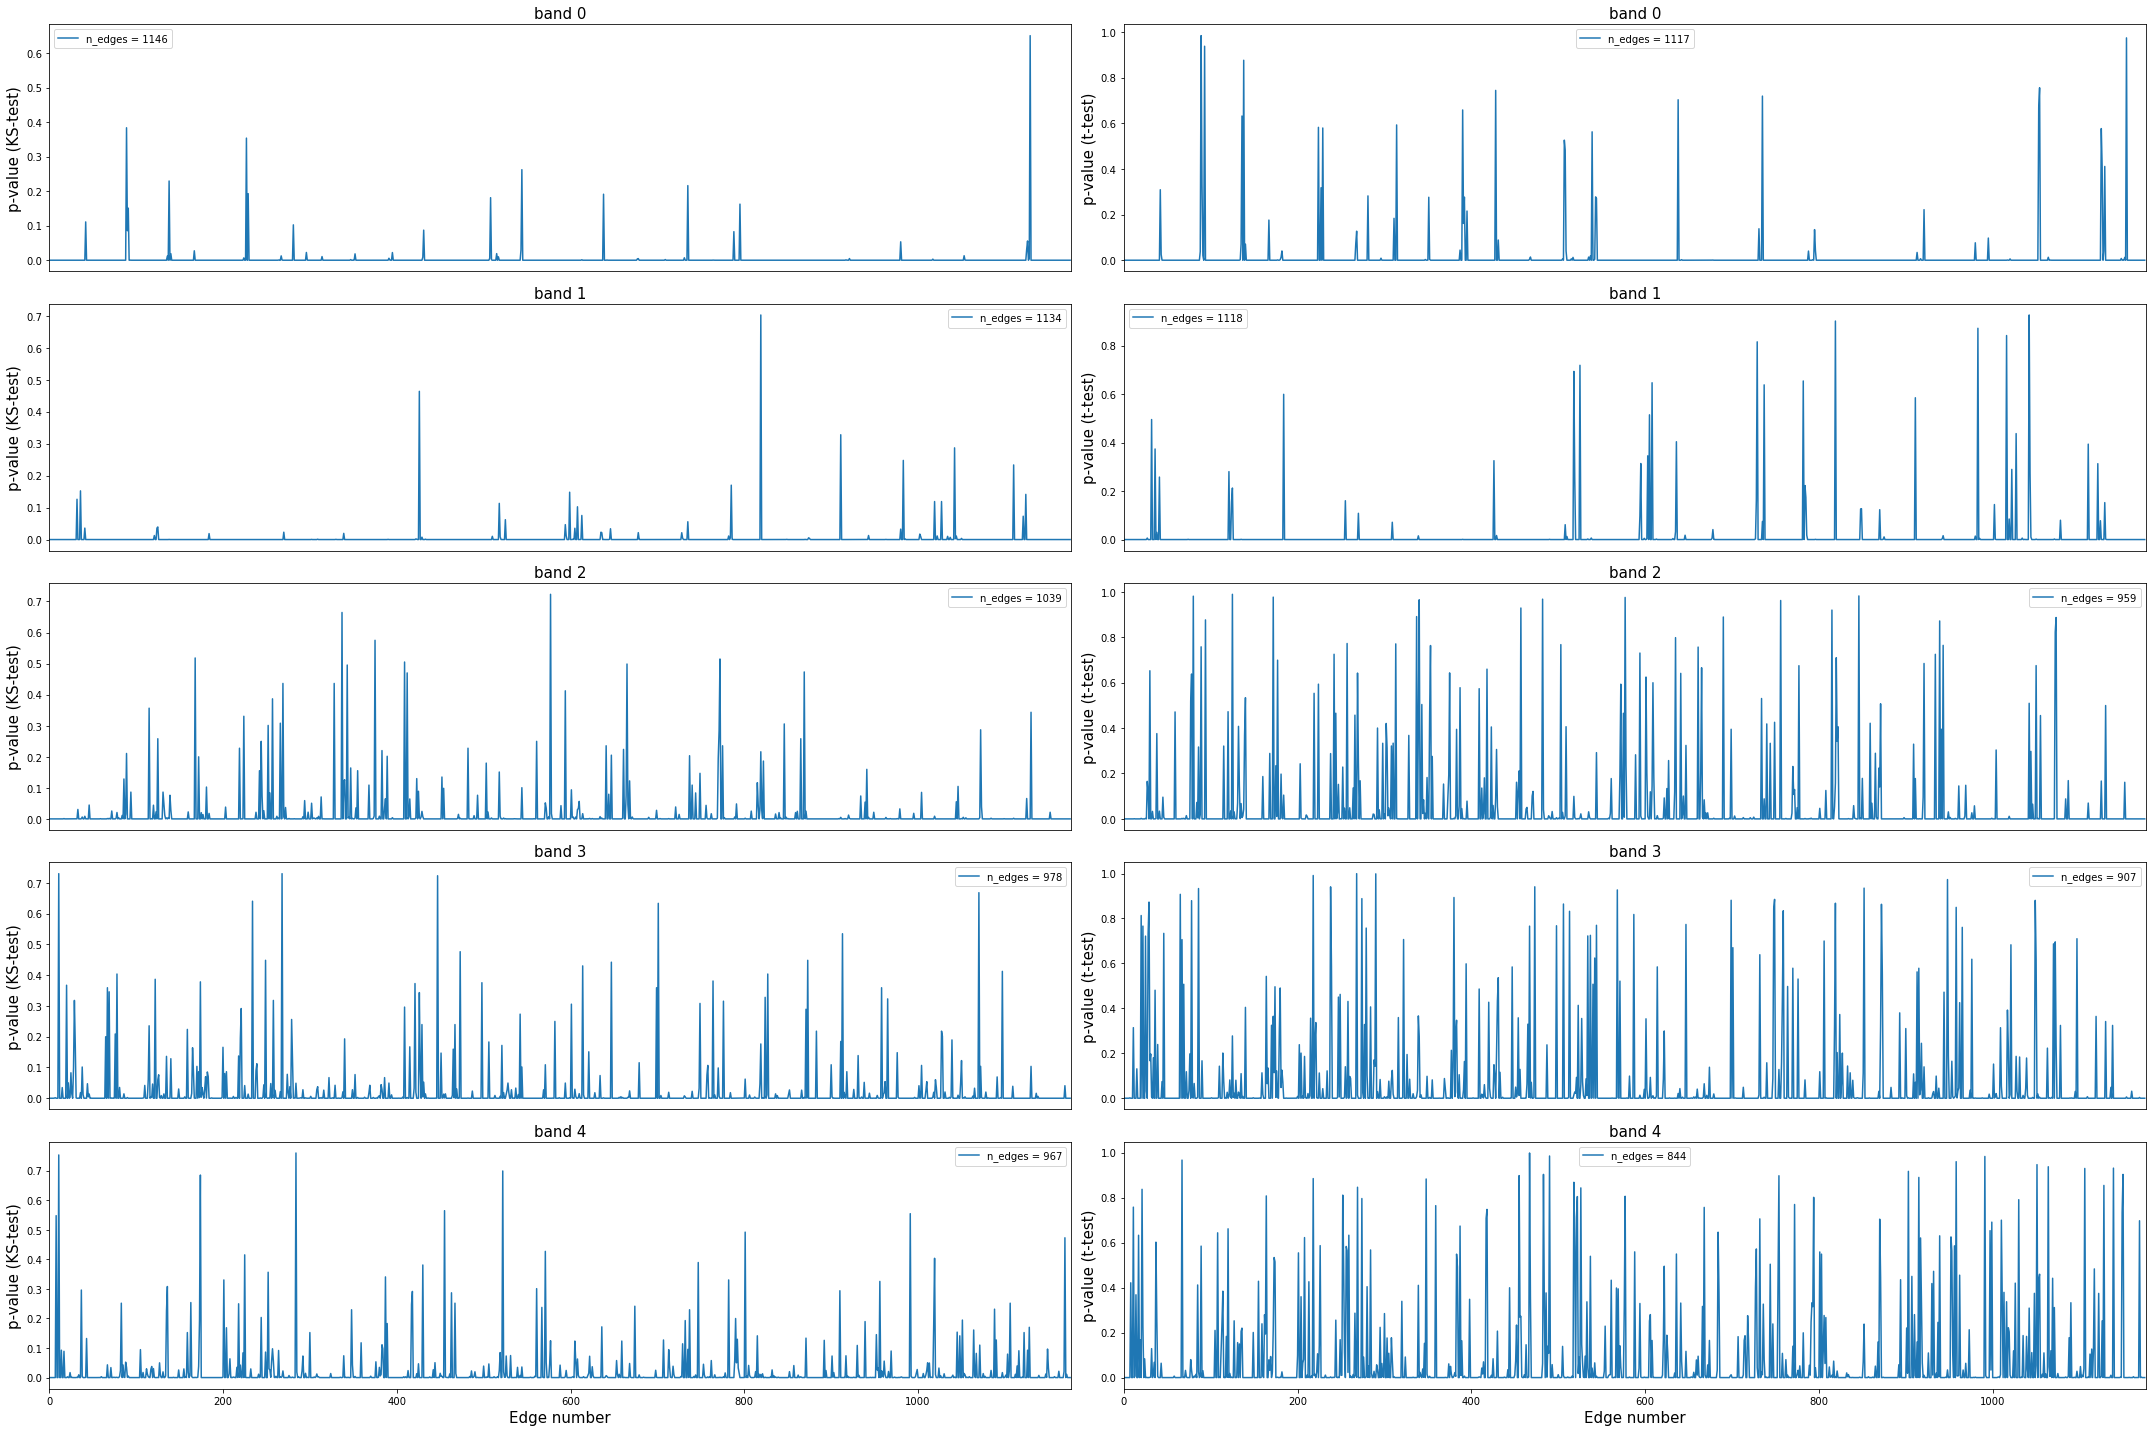

In [71]:
plt.figure(figsize=(30,20))
count = 1
for i in range(plv.sizes['freqs']):
    plt.subplot(5,2,count)
    # Plot KS-test p-value
    plt.plot(p_values[:,0,i], label=f'n_edges = {np.sum(p_values[:,0,i]<p)}')
    plt.ylabel('p-value (KS-test)', fontsize=15)
    plt.title(f'band {i}', fontsize=15)
    plt.xlim([0,p_values.shape[0]])
    if i == 4: plt.xlabel('Edge number', fontsize=15)
    else: plt.xticks([])
    plt.legend()
    count += 1
    plt.subplot(5,2,count)
    # Plot t-test p-value
    plt.plot(p_values[:,1,i], label=f'n_edges = {np.sum(p_values[:,1,i]<p)}')
    plt.ylabel('p-value (t-test)', fontsize=15)
    count += 1
    if i == 4: plt.xlabel('Edge number', fontsize=15)
    else: plt.xticks([])
    plt.title(f'band {i}', fontsize=15)
    plt.xlim([0,p_values.shape[0]])
    plt.legend()
    plt.tight_layout()
plt.savefig('img/ks_test.png', dpi=200)

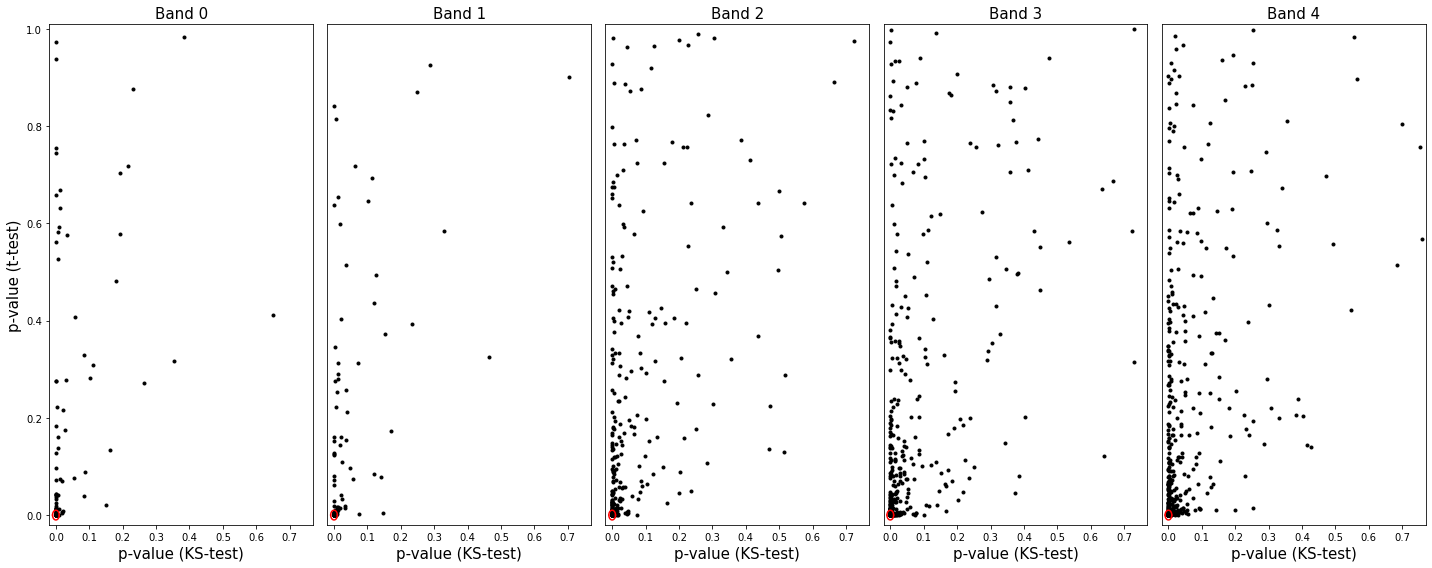

In [72]:
plt.figure(figsize=(20,8))
for i in range(plv.sizes['freqs']):
    plt.subplot(1,5,i+1)
    # Create scatter plot 
    plt.scatter(p_values[:,0,i],p_values[:,1,i], marker='.', color='k')
    # Surround the area corresponding to the links with low p-value 
    x = np.linspace(-p,p,100)
    y = np.sqrt(p**2-x**2)
    plt.plot(x,y,'r')
    plt.plot(x,-y,'r')
    if i==0: plt.ylabel('p-value (t-test)', fontsize=15)
    if i>0: plt.yticks([])
    plt.xlabel('p-value (KS-test)', fontsize=15)
    plt.title(f'Band {i}', fontsize=15)
    plt.ylim(-0.02, p_values[:,1,:].max()+0.01)
    plt.xlim(-0.02, p_values[:,0,:].max()+0.01)
plt.tight_layout()

In [93]:
x_s, x_t, _ = _extract_roi(plv.roi.values, '-')

In [94]:
for i in range(len(x_s)):
    x_s[i] = x_s[i].replace('roi_', '')
    x_t[i] = x_t[i].replace('roi_', '')
x_s = x_s.astype(int)
x_t = x_t.astype(int)

In [95]:
ks_mat = np.zeros((plv.sizes['freqs'],ses.data.sizes['roi'],ses.data.sizes['roi']))
for i in range(plv.sizes['freqs']):
    idx         = (p_values[:,0,i]<p)*(p_values[:,1,i]<p)
    x_s_i,x_t_i = x_s[idx], x_t[idx]
    ks_mat[i,x_s_i,x_t_i] = ks_mat[i,x_t_i,x_s_i] = 1

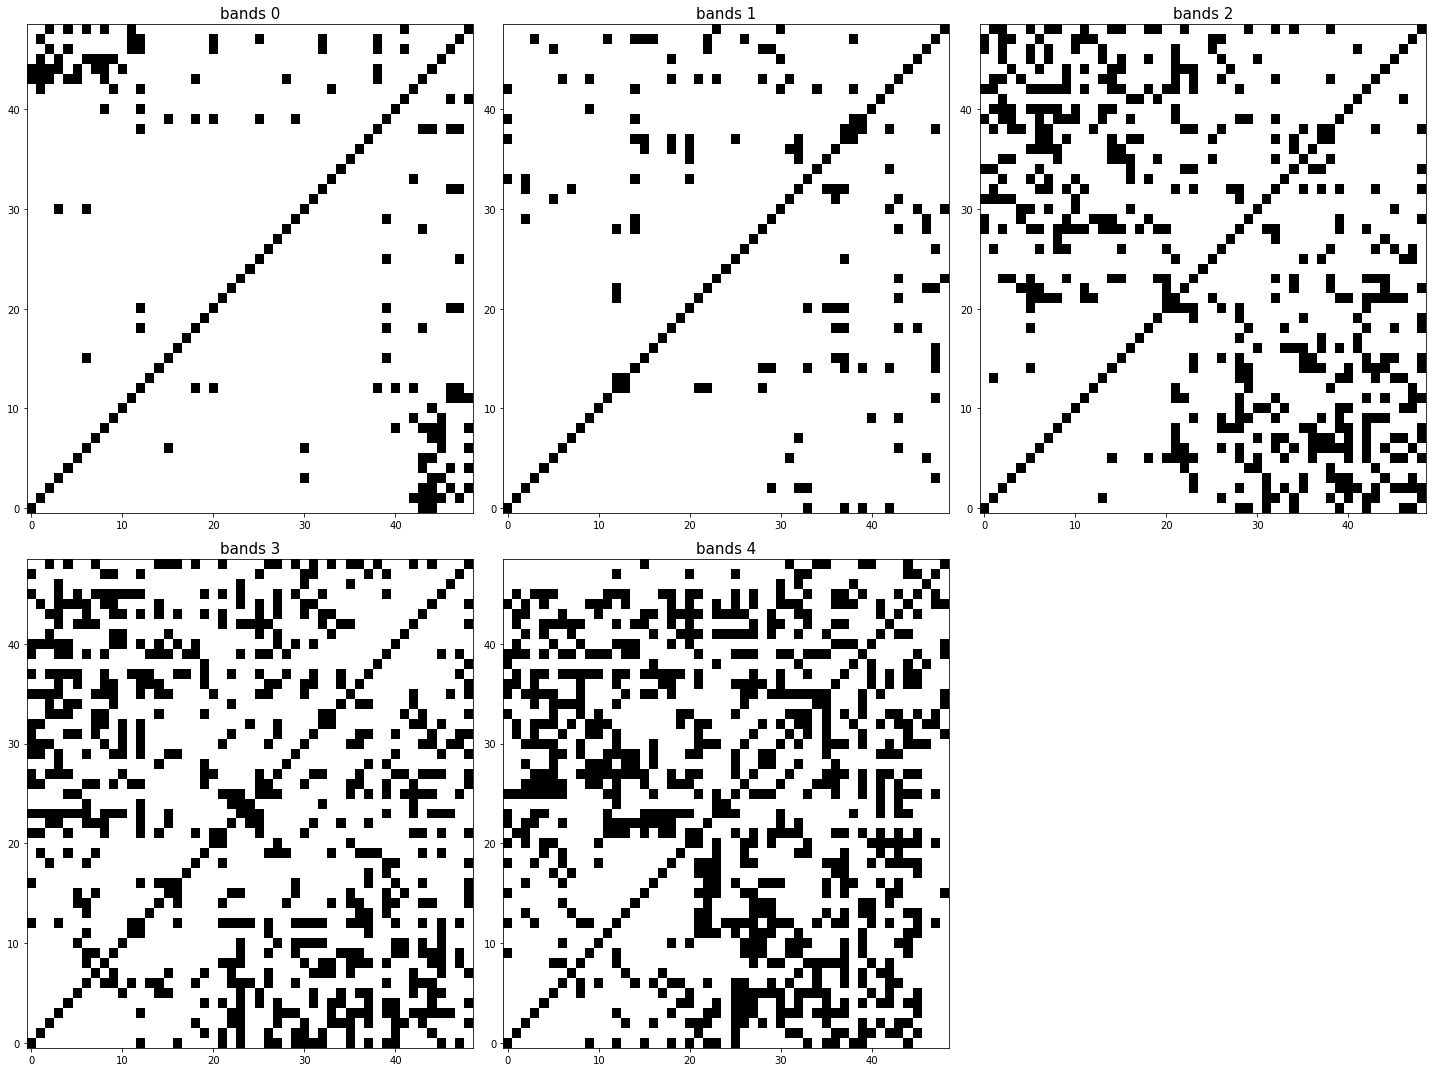

In [97]:
plt.figure(figsize=(20,15))
for i in range(plv.sizes['freqs']):
    plt.subplot(2,3,i+1)
    plt.imshow(ks_mat[i], aspect='auto', origin = 'lower', cmap='gray')
    #plt.xticks(range(data.sizes['roi']), data.roi.values, rotation=270)
    #plt.yticks(range(data.sizes['roi']), data.roi.values)
    plt.title(f'bands {i}', fontsize=15)
plt.tight_layout()

#### Checking a few histograms with p<1e-10

In [98]:
# Edges with signigicative coherence for all bands
idx = (p_values[:,0,0]<p)*(p_values[:,0,1]<p)*(p_values[:,0,2]<p)*(p_values[:,0,3]<p)*(p_values[:,0,4]<p)
idx = np.logical_and(idx,( (p_values[:,1,0]<p)*(p_values[:,1,1]<p)*(p_values[:,1,2]<p)*(p_values[:,1,3]<p)*(p_values[:,1,4]<p) ))

In [99]:
# Sample four edge indexes
ei  = np.sort( np.random.choice( np.where(idx==True)[0], 4) )

100%|██████████| 5/5 [00:00<00:00,  7.67it/s]


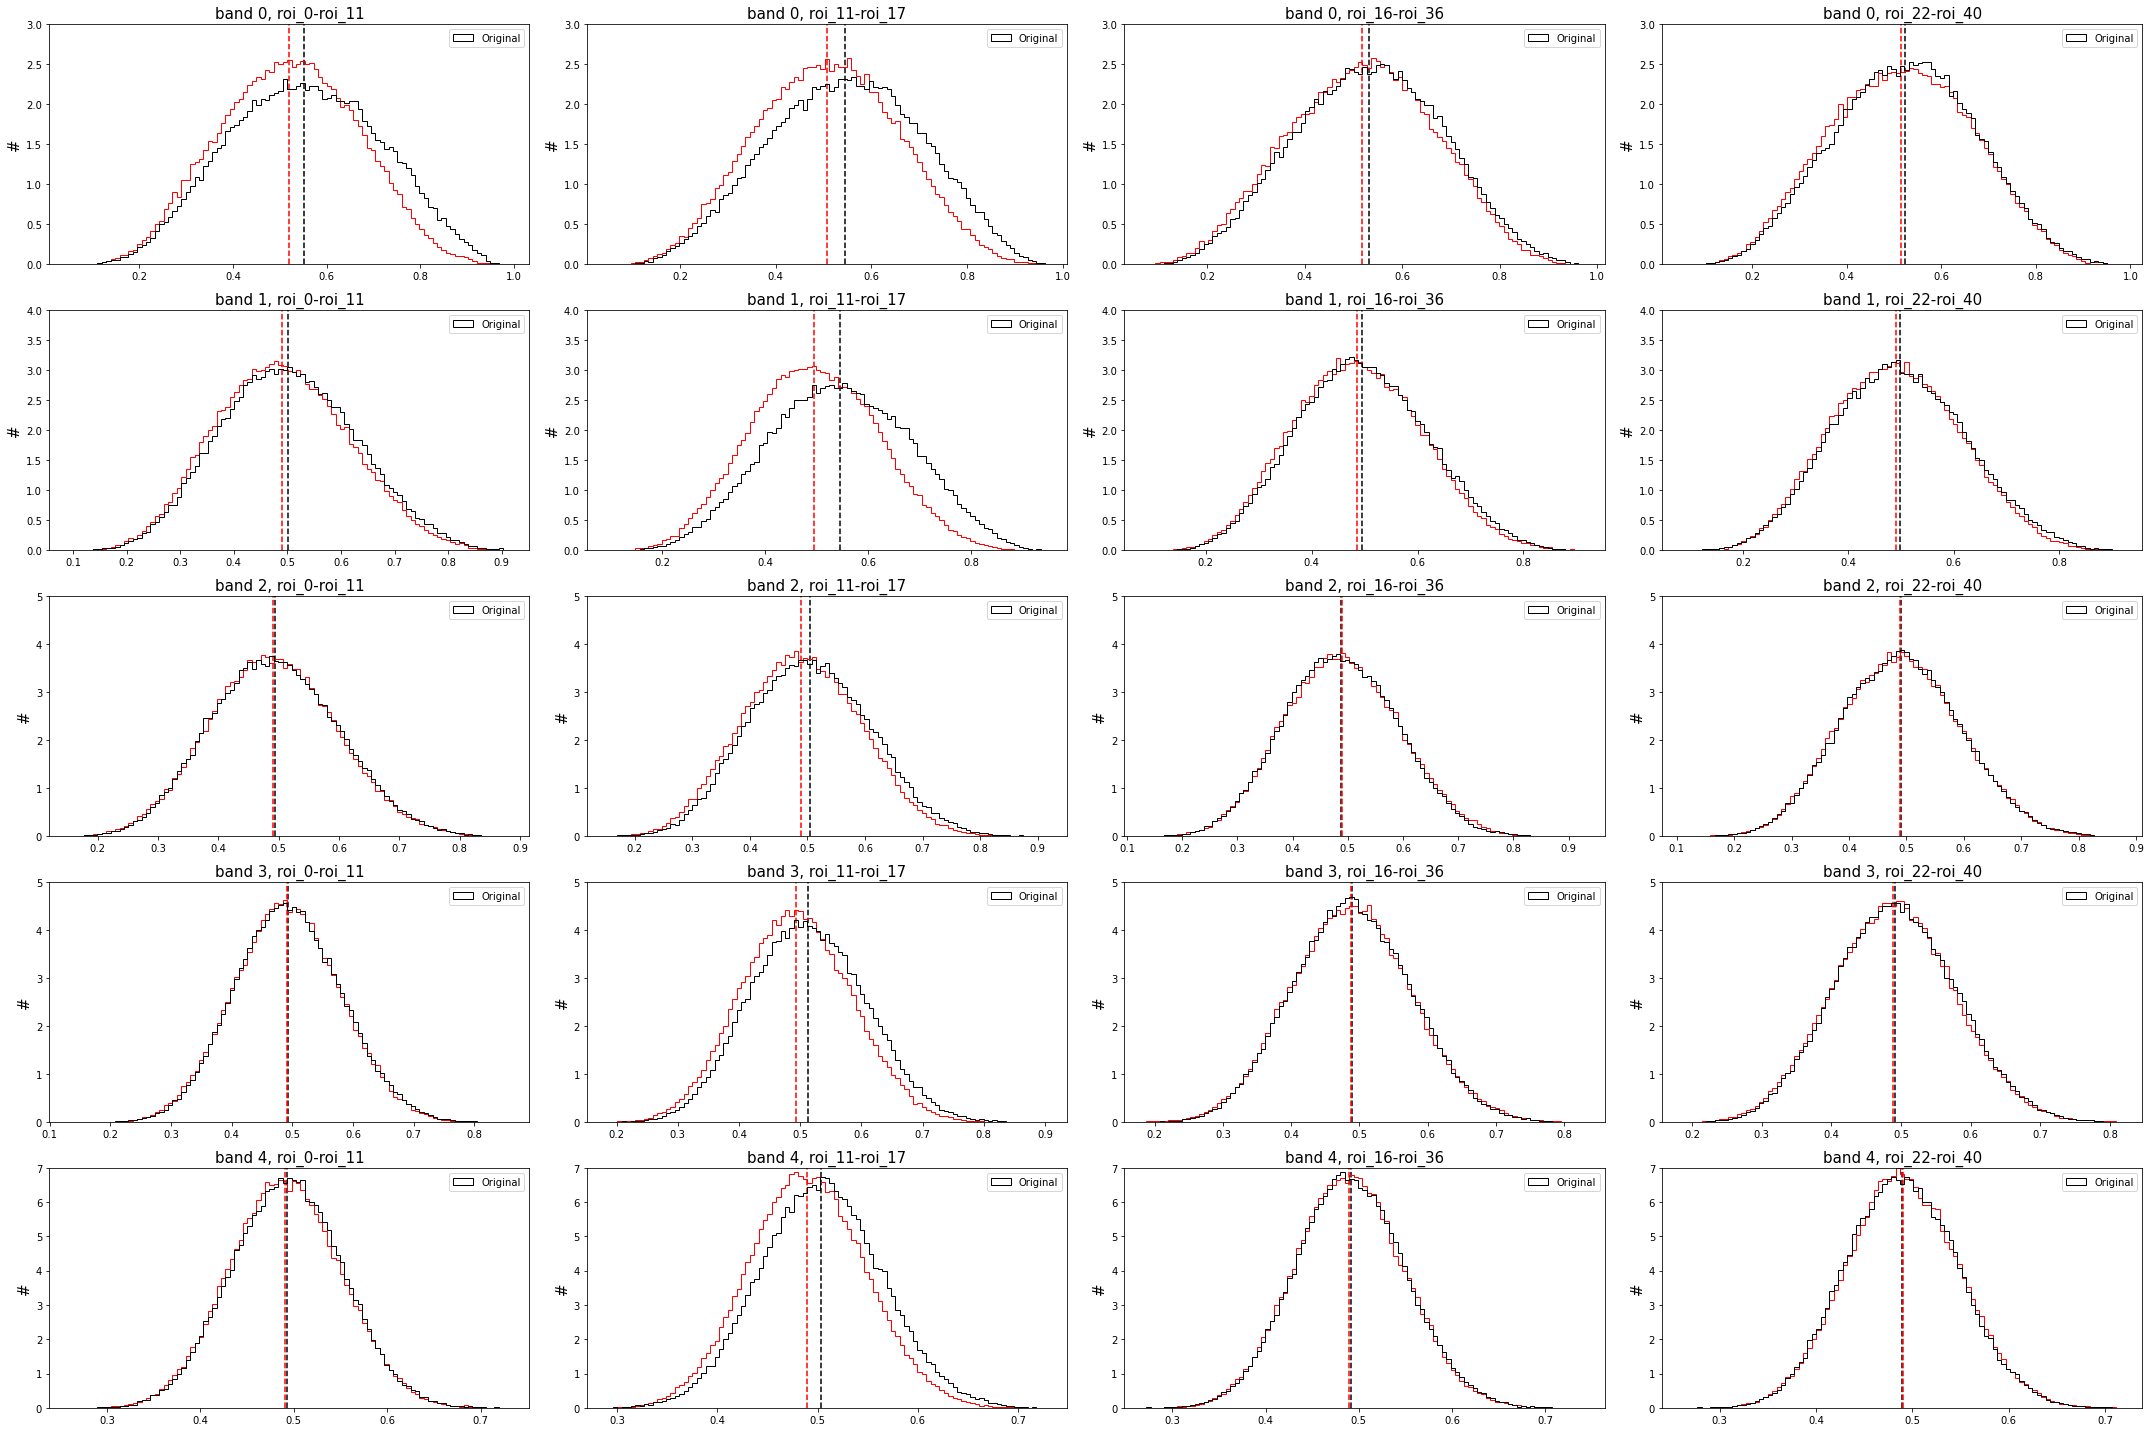

In [104]:
# Saving distributions for trial shuffling surrogates
count = 1
y_max = [3,4,5,5,7]
plt.figure(figsize=(30,20))
for i in tqdm( range(plv.sizes['freqs']) ):
    for r in ei:#tqdm( range(coh.sizes['roi']) ):
        bins = np.linspace(plv.isel(freqs=i,roi=r).min(),plv.isel(freqs=i,roi=r).max(),100)
        plt.subplot(plv.sizes['freqs'],len(ei),count)
        plt.hist(plv_surr.isel(freqs=i,roi=r).values.flatten(), bins=bins, density=True, histtype='step', fill=False, color='r')
        plt.hist( plv.isel(freqs=i,roi=r).values.flatten(), bins=bins,  density=True, histtype='step', fill=False, color='k', label='Original', lw=1);
        # Compute mean to plot
        m_orig = plv.isel(freqs=i,roi=r).mean()
        m_surr = plv_surr.isel(freqs=i,roi=r).mean()
        # Plot mean values as vertical bar
        plt.ylim(0,y_max[i])
        plt.vlines(m_orig, 0, 10, colors='k', linestyles='dashed')
        plt.vlines(m_surr, 0, 10, colors='r', linestyles='dashed')
        plt.title(f'band {i}, {plv.roi.values[r]}', fontsize=15)
        plt.ylabel('#', fontsize=15) 
        plt.legend()
        count += 1
plt.tight_layout()

### Gaussian noise

In [105]:
data = np.random.normal(size=(540,10,3651))

In [108]:
coh_n=conn_spec_plv(data, **kw)

WARNING | No time vector. A default one is created
WARNING | No regions of interest are provided (roi). Default ones are created
Defining temporal windows
    Definition of sliding windows (len=0.5, start=0.0, stop=3.645, step=0.02)
    158 windows defined
Compute spectral phase-locking value (n_pairs=45, n_freqs=50, decim=15)
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done   4 out of  10 | elapsed:    8.8s remaining:   13.2s
[Parallel(n_jobs=40)]: Done   7 out of  10 | elapsed:    9.8s remaining:    4.2s
[Parallel(n_jobs=40)]: Done  10 out of  10 | elapsed:   10.7s remaining:    0.0s
[Parallel(n_jobs=40)]: Done  10 out of  10 | elapsed:   10.7s finished


  0%|          |  : 0/45 [00:00<?,       ?it/s]

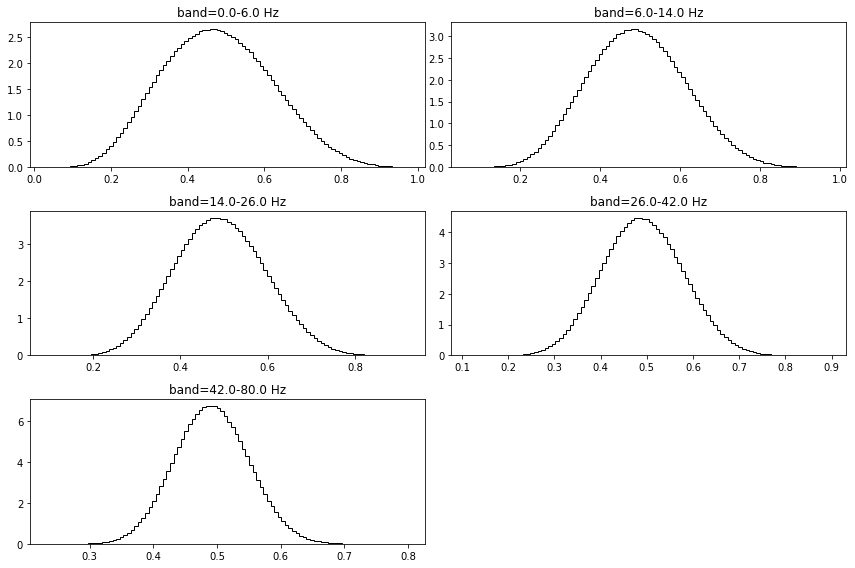

In [109]:
plt.figure(figsize=(12,8))
for j in range(5):
    plt.subplot(3,2,j+1)
    plt.title(f'band={foi[j,0]}-{foi[j,1]} Hz')
    plt.hist(coh_n[:,:,j,:].values.flatten(), bins=100, density=True, histtype='step', fill=False, color='k')
plt.tight_layout()